In [1]:
% matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch, torch.utils.data, torchvision
import PIL
import os.path
import time
import skimage, skimage.io
import time
import copy
from my_utils import *

In [2]:
MEAN = [0.485, 0.456, 0.406] # expected by pretrained resnet18
STD = [0.229, 0.224, 0.225] # expected by pretrained resnet18

# Toy Model

The idea with the toy model is to only look at those whales for which at least 11 different images are present. My hope is that this will allow me to find out what the best way is to train a neural network to pick up those features which distinguish the whales. Later I can retrain the toy model on the whole data set. Note that I will also include the new whales because they may not have any common features.

In [3]:
# load the data and add a column for occurrences
df = pandas.read_csv('./data/train.csv')
grouped = df.groupby('Id')
df['occurrences'] =  grouped.Id.transform('count')

In [4]:
# pick 11 samples from each class. One of these samples will go into the validation set.

# throw away all the labels which have fewer than 11 images associated with them and all the new whales
toy_df = df[(df.occurrences >= 11) & (df.Id != 'new_whale')]

# randomly pick 11 images for each label (without replacement)
random_pick_11 = lambda x: x.sample(11)
toy_df = toy_df.groupby('Id',group_keys=False).apply(random_pick_11)
toy_df

,Image,Id,occurrences
5013,824b2725.jpg,w_0e737d0,17
739,12779baa.jpg,w_0e737d0,17
2666,45880deb.jpg,w_0e737d0,17
9697,fc0c2037.jpg,w_0e737d0,17
5349,8b446746.jpg,w_0e737d0,17
4474,74568e8f.jpg,w_0e737d0,17
3647,5f566f62.jpg,w_0e737d0,17
3606,5e2fcd9d.jpg,w_0e737d0,17
3945,677a1285.jpg,w_0e737d0,17
4135,6c5ad43e.jpg,w_0e737d0,17


In [5]:
# Let's check that I really picked only 11 whales per label
toy_df[toy_df.Id=='w_0e737d0']

,Image,Id,occurrences
5013,824b2725.jpg,w_0e737d0,17
739,12779baa.jpg,w_0e737d0,17
2666,45880deb.jpg,w_0e737d0,17
9697,fc0c2037.jpg,w_0e737d0,17
5349,8b446746.jpg,w_0e737d0,17
4474,74568e8f.jpg,w_0e737d0,17
3647,5f566f62.jpg,w_0e737d0,17
3606,5e2fcd9d.jpg,w_0e737d0,17
3945,677a1285.jpg,w_0e737d0,17
4135,6c5ad43e.jpg,w_0e737d0,17


In [6]:
# define transformations with data augmentation
transforms_augm = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=20.0), # Data augmentation
    torchvision.transforms.RandomGrayscale(), # Data augmentation
    # torchvision.transforms.Resize((224,int(224.0*16.0/9.0))),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), # Expected by pretrained neural network
    torchvision.transforms.Normalize(MEAN, STD) # Expected by pretrained neural network
    ])


# Create a validation set which contains exactly one image per label. 
# The rest of the data is contained in the training set.
data = WhaleDataset(toy_df,'./data/',transform=transforms_augm)
val_indices = range(0,toy_df.Image.unique().size,11)
train_indices = [ind for ind in range(toy_df.Image.unique().size) if ind not in val_indices]
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)


In [13]:
# Note I should probably change this so that the validation set does not use data augmentation
toy_dataloader = {'train': torch.utils.data.DataLoader(data,\
                                            batch_size=4,\
                                            shuffle=False,\
                                            num_workers=4,\
                                            sampler=train_sampler),\
                 'val':torch.utils.data.DataLoader(data,\
                                            batch_size=4,\
                                            shuffle=False,\
                                            num_workers=4,\
                                            sampler=val_sampler)}

In [7]:
# Define the model
toy_model = torchvision.models.resnet18(pretrained=True)

# freeze layers
for param in toy_model.parameters():
    param.requires_grad = False

# create new last layer (this is automatically unfrozen)
# The dimensions are given by those of the previous layer (num_in)
# and the number of categories for the Whale data set (num_out)
num_in = toy_model.fc.in_features
num_out = toy_df.Id.unique().shape[0]
toy_model.fc = torch.nn.Linear(num_in,num_out)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
toy_model = toy_model.to(device)
toy_model.fc

Linear(in_features=512, out_features=56, bias=True)

In [8]:
# Choose the loss function (criterion) and optimizer
criterion = torch.nn.CrossEntropyLoss()
toy_optimizer = torch.optim.Adam(toy_model.fc.parameters(),lr=0.001)

In [10]:
# How large can we make the learning rate? Use the method from the fast.ai MOOC to 
# find a good learning rate
toy_model, lr_vals, loss_vals, acc_vals = find_learning_rate(
    toy_model,toy_dataloader['train'],criterion,toy_optimizer,device)

Elapsed time: 66.9433 lr: 1.0000e-04 Loss: 4.2014 Acc: 0.0232
Elapsed time: 133.6771 lr: 1.2000e-04 Loss: 4.0260 Acc: 0.0304
Elapsed time: 200.6992 lr: 1.4400e-04 Loss: 3.9582 Acc: 0.0500
Elapsed time: 266.2936 lr: 1.7280e-04 Loss: 3.9040 Acc: 0.0500
Elapsed time: 331.4584 lr: 2.0736e-04 Loss: 3.8286 Acc: 0.0607
Elapsed time: 396.5420 lr: 2.4883e-04 Loss: 3.7055 Acc: 0.1161
Elapsed time: 461.9859 lr: 2.9860e-04 Loss: 3.6197 Acc: 0.1250
Elapsed time: 527.6861 lr: 3.5832e-04 Loss: 3.5117 Acc: 0.1625
Elapsed time: 592.9810 lr: 4.2998e-04 Loss: 3.3596 Acc: 0.1804
Elapsed time: 658.0677 lr: 5.1598e-04 Loss: 3.2070 Acc: 0.2054
Elapsed time: 725.3695 lr: 6.1917e-04 Loss: 3.1097 Acc: 0.2375
Elapsed time: 793.9064 lr: 7.4301e-04 Loss: 2.9768 Acc: 0.2875
Elapsed time: 862.8569 lr: 8.9161e-04 Loss: 2.7765 Acc: 0.2875
Elapsed time: 931.7347 lr: 1.0699e-03 Loss: 2.6457 Acc: 0.3446
Elapsed time: 998.6259 lr: 1.2839e-03 Loss: 2.6055 Acc: 0.3304
Elapsed time: 1065.8889 lr: 1.5407e-03 Loss: 2.5473 Acc:

<IPython.core.display.Javascript object>


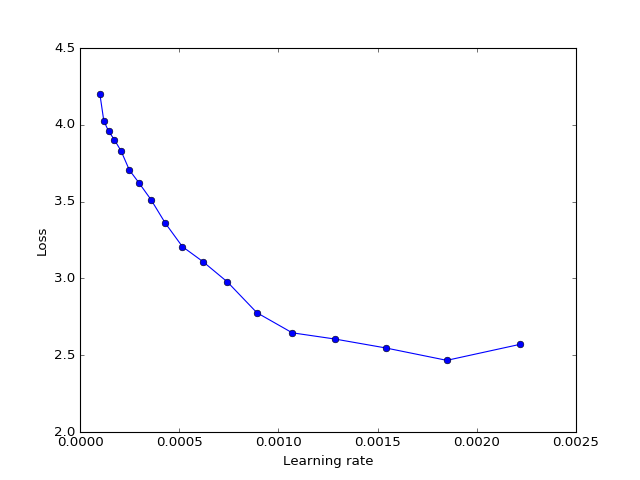

In [13]:
plt.figure()
plt.plot(lr_vals,loss_vals,'-ob')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

Pick learning rate of 0.001 which is relatively large, yet still results in a decrease in the loss. 

In [14]:
# Save the mode at this point in case the kernel gets shutdown.
# torch.save(toy_model,'toy_model_only_last_layer_trained.pt')

In [11]:
# Load model if necessary
toy_model = torch.load('toy_model_only_last_layer_trained.pt')

In [14]:
# Train the final layer of the model. The function learn_with_restarts 
# uses cosine annealing and restarts after T_max epochs. This is a trick from the fast.ai MOOC.
toy_optimizer = torch.optim.Adam(toy_model.fc.parameters(),lr=0.001)
toy_model, loss_dict, acc_dict = train_with_restart(
    toy_model,toy_dataloader,criterion,toy_optimizer,device)

Epoch 0 / 20
Training: Elapsed time: 66.8637 Loss: 2.5012 Acc: 0.3679
Validation: Elapsed time: 73.4350 Loss: 1.5943 Acc: 0.5357
Epoch 1 / 20
Training: Elapsed time: 140.9293 Loss: 2.2371 Acc: 0.4357
Validation: Elapsed time: 147.5626 Loss: 1.4907 Acc: 0.5536
Epoch 2 / 20
Training: Elapsed time: 215.5678 Loss: 2.0880 Acc: 0.4679
Validation: Elapsed time: 222.2091 Loss: 1.6146 Acc: 0.5714
Epoch 3 / 20
Training: Elapsed time: 289.8434 Loss: 1.9674 Acc: 0.4911
Validation: Elapsed time: 296.5587 Loss: 1.4318 Acc: 0.6071
Epoch 4 / 20
Training: Elapsed time: 364.5534 Loss: 1.8424 Acc: 0.5482
Validation: Elapsed time: 371.0443 Loss: 1.5175 Acc: 0.6250
Epoch 5 / 20
Training: Elapsed time: 437.8785 Loss: 1.6628 Acc: 0.5589
Validation: Elapsed time: 444.6496 Loss: 1.3985 Acc: 0.6250
Epoch 6 / 20
Training: Elapsed time: 510.7821 Loss: 1.5796 Acc: 0.6286
Validation: Elapsed time: 517.3355 Loss: 1.4670 Acc: 0.5893
Epoch 7 / 20
Training: Elapsed time: 583.9760 Loss: 1.5613 Acc: 0.6304
Validation: El

In [15]:
# Save the mode at this point in case the kernel gets shutdown.
torch.save(toy_model,'toy_model_only_last_layer_trained.pt')

<IPython.core.display.Javascript object>


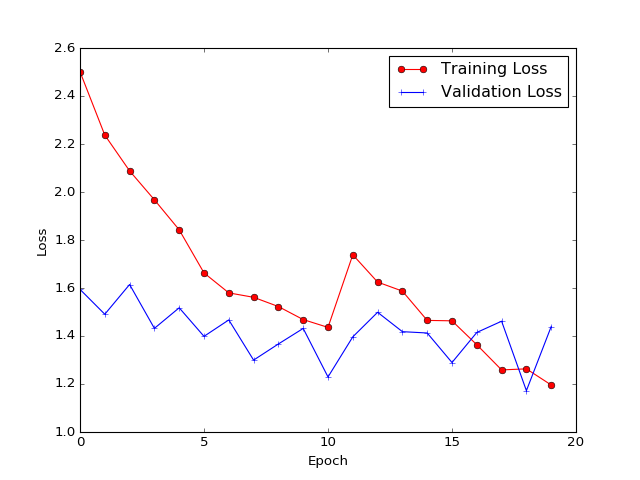

In [16]:
# Analyse the training loss data
plt.figure()
plt.plot(range(20),loss_dict['train'],'-or',label='Training Loss')
plt.plot(range(20),loss_dict['val'],'-+b',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

Note that the Loss increases sharply after 10 epochs. This is due to the restart of the learning rate. A similar feature can be seen in the accuracy data below.

<IPython.core.display.Javascript object>


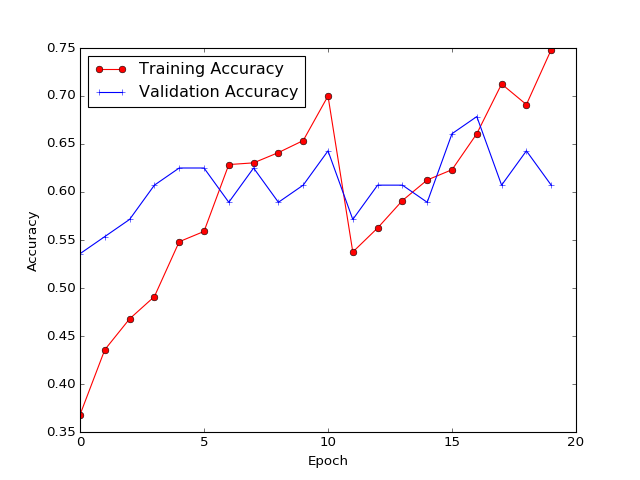

In [17]:
# Analyse the training accuracy data
plt.figure()
plt.plot(range(20),acc_dict['train'],'-or',label='Training Accuracy')
plt.plot(range(20),acc_dict['val'],'-+b',label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

So far we have only trained the final layer of the toy_model. Now it is time to train the other layers of the toy_models as well, so that they can pick up those features which are important for whale identification. I am using a trick from the fast.ai MOOC which involves using different learning rates for different layers.

In [22]:
# Load model if necessary
toy_model = torch.load('toy_model_only_last_layer_trained.pt')

In [23]:
# unfreeze layers
for param in toy_model.layer4.parameters():
    param.requires_grad = True
for param in toy_model.layer3.parameters():
    param.requires_grad = True
for param in toy_model.layer2.parameters():
    param.requires_grad = True
for param in toy_model.layer1.parameters():
    param.requires_grad = True

# freeze layers
# for param in toy_model.layer4.parameters():
#     param.requires_grad = False

In [24]:
lr = 0.001
param_options = [{'params': toy_model.layer1.parameters(), 'lr':lr/20.0},\
                {'params': toy_model.layer2.parameters(), 'lr':lr/10.0},\
                {'params': toy_model.layer3.parameters(), 'lr':lr/5.0},\
                {'params': toy_model.layer4.parameters(), 'lr':lr/2.0}]
toy_optimizer = torch.optim.Adam(param_options,lr=lr)

In [25]:
toy_model, loss_dict_2, acc_dict_2 = train_with_restart(
    toy_model,toy_dataloader,criterion,toy_optimizer,device)

Epoch 0 / 20
Training: Elapsed time: 192.6044 Loss: 2.4788 Acc: 0.3554
Validation: Elapsed time: 199.5364 Loss: 1.6596 Acc: 0.5357
Epoch 1 / 20
Training: Elapsed time: 390.1038 Loss: 1.3021 Acc: 0.6393
Validation: Elapsed time: 397.0395 Loss: 1.2604 Acc: 0.7143
Epoch 2 / 20
Training: Elapsed time: 585.1729 Loss: 0.9069 Acc: 0.7339
Validation: Elapsed time: 592.0400 Loss: 1.1308 Acc: 0.7321
Epoch 3 / 20
Training: Elapsed time: 782.7720 Loss: 0.6209 Acc: 0.8214
Validation: Elapsed time: 789.7291 Loss: 1.1052 Acc: 0.7500
Epoch 4 / 20
Training: Elapsed time: 981.9603 Loss: 0.5129 Acc: 0.8607
Validation: Elapsed time: 989.0893 Loss: 0.6928 Acc: 0.8393
Epoch 5 / 20
Training: Elapsed time: 1181.0524 Loss: 0.2895 Acc: 0.9232
Validation: Elapsed time: 1188.1810 Loss: 0.5635 Acc: 0.8214
Epoch 6 / 20
Training: Elapsed time: 1379.7370 Loss: 0.1463 Acc: 0.9661
Validation: Elapsed time: 1386.7933 Loss: 0.5319 Acc: 0.8750
Epoch 7 / 20
Training: Elapsed time: 1577.7204 Loss: 0.1038 Acc: 0.9804
Validat

In [26]:
# Save the mode at this point in case the kernel gets shutdown.
torch.save(toy_model,'./toy_model_all_layers_trained.pt')

<IPython.core.display.Javascript object>


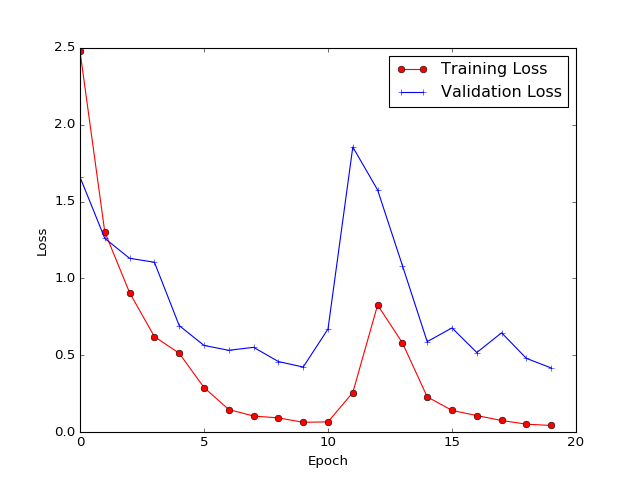

In [27]:
# Analyse the training loss data
plt.figure()
plt.plot(range(20),loss_dict_2['train'],'-or',label='Training Loss')
plt.plot(range(20),loss_dict_2['val'],'-+b',label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

<IPython.core.display.Javascript object>


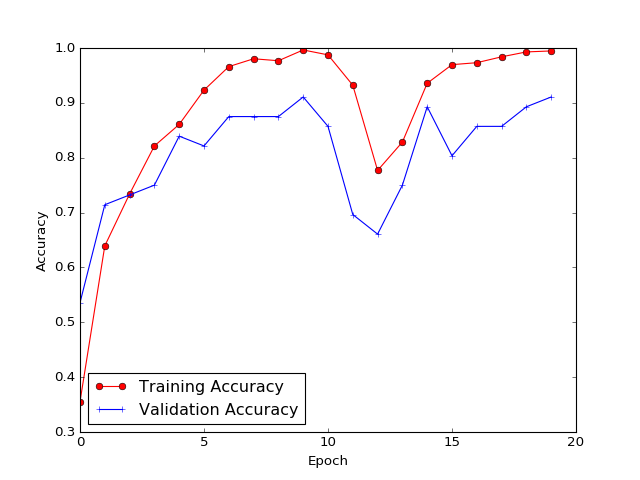

In [28]:
# Analyse the training accuracy data
plt.figure()
plt.plot(range(20),acc_dict_2['train'],'-or',label='Training Accuracy')
plt.plot(range(20),acc_dict_2['val'],'-+b',label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)